In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Surrogate approx

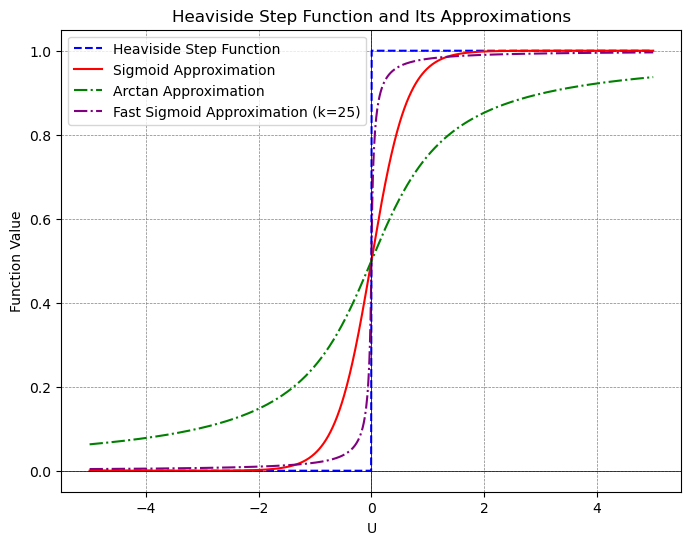

In [3]:
# Define Heaviside step function
def heaviside_step(U):
    return np.where(U >= 0, 1, 0)

# Define sigmoid approximation


def sigmoid_approx(U, beta=np.pi, theta=0):
    return 1 / (1 + np.exp(-beta * (U - theta)))

# Define arctan derivative approximation


def arctan_approx(U, beta=1, theta=0):
    return 0.5 + (1 / np.pi) * np.arctan(beta * (U - theta))


def fast_sigmoid(U, beta=1, theta=0, k = 10):
    return 0.5  * k * beta * (U - theta) / (1 + k * beta * np.abs(U - theta)) + 0.5


# Generate U values
U_values = np.linspace(-5, 5, 1000)

# Calculate Heaviside step function
heaviside_result = heaviside_step(U_values)

# Calculate sigmoid approximation
sigmoid_result = sigmoid_approx(U_values)

# Calculate arctan approximation
arctan_result = arctan_approx(U_values)

fast_sigmoid_result = fast_sigmoid(U_values, k=25)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(U_values, heaviside_result, label='Heaviside Step Function',
         linestyle='--', color='blue')
plt.plot(U_values, sigmoid_result, label='Sigmoid Approximation', color='red')
plt.plot(U_values, arctan_result, label='Arctan Approximation',
         linestyle='-.', color='green')
plt.plot(U_values, fast_sigmoid_result, label=f'Fast Sigmoid Approximation (k=25)',
            linestyle='-.', color='purple')
# Adding labels and annotations
plt.title('Heaviside Step Function and Its Approximations')
plt.xlabel('U')
plt.ylabel('Function Value')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

## Encoding part

In [4]:
# Checking that the rate encodings of the MNIST image, if averaged, can return something close to the original image
import numpy as np
import matplotlib.pyplot as plt
import snntorch as snn
from snntorch import utils
import torch
import os
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

In [5]:
# Training Parameters
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
batch_size = 1
data_path = './data'
os.makedirs(data_path, exist_ok=True)
num_classes = 10  # MNIST has 10 output classes

# Torch Variables
dtype = torch.float


# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

subset = 10
mnist_train = utils.data_subset(mnist_train, subset)
print(f"The size of mnist_train is {len(mnist_train)}")

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

The size of mnist_train is 6000


Data shape: torch.Size([1, 1, 28, 28]) Targets shape: torch.Size([1])
Spike Data shape: torch.Size([2, 1, 1, 28, 28])  (Time, Batch, Channels, Height, Width)


Text(0.5, 1.0, 'Average Spikes over 100 Timesteps')

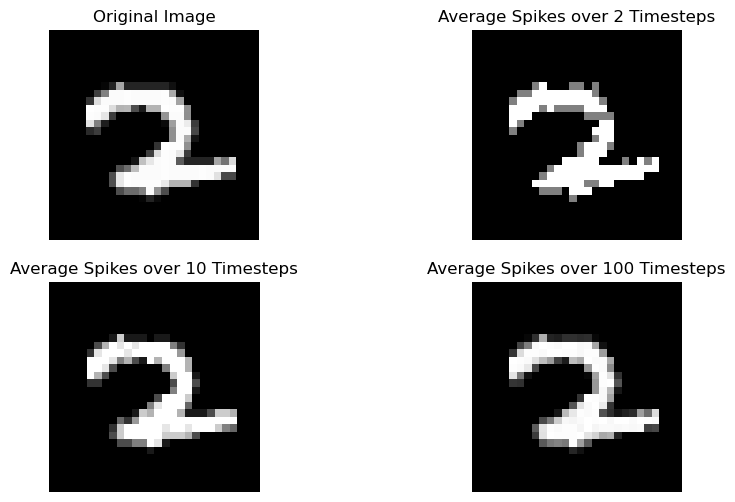

In [6]:
from snntorch import spikegen

# Iterate through minibatches
data = iter(train_loader)
data_it, targets_it = next(data)

print(f"Data shape: {data_it.shape}", f"Targets shape: {targets_it.shape}")

num_steps = 2
num_steps_2 = 10
num_steps_3 = 100
# Spiking Data
spike_data = spikegen.rate(data_it, num_steps=num_steps)
spike_data_2 = spikegen.rate(data_it, num_steps=num_steps_2)
spike_data_3 = spikegen.rate(data_it, num_steps=num_steps_3)

print(f"Spike Data shape: {spike_data.shape}",
      " (Time, Batch, Channels, Height, Width)")

spike_data_sample = spike_data[:, 0, 0]
spike_data_sample_2 = spike_data_2[:, 0, 0]
spike_data_sample_3 = spike_data_3[:, 0, 0]

# Plotting
plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.imshow(data_it[0, 0], cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(2, 2, 2)
plt.imshow(spike_data_sample.mean(axis=0).reshape((28, -1)).cpu(), cmap='gray')
plt.axis('off')
plt.title(f'Average Spikes over {num_steps} Timesteps')
plt.subplot(2, 2, 3)
plt.imshow(spike_data_sample_2.mean(
    axis=0).reshape((28, -1)).cpu(), cmap='gray')
plt.axis('off')
plt.title(f'Average Spikes over {num_steps_2} Timesteps')
plt.subplot(2, 2, 4)
plt.imshow(spike_data_sample_3.mean(
    axis=0).reshape((28, -1)).cpu(), cmap='gray')
plt.axis('off')
plt.title(f'Average Spikes over {num_steps_3} Timesteps')

## LiF model tests

In [7]:
def plot_cur_mem_spk(cur, mem, spk, thr_line=False, vline=False, title=False, ylim_max1=1.25, ylim_max2=1.25):
    # Generate Plots
    fig, ax = plt.subplots(3, figsize=(8, 6), sharex=True,
                           gridspec_kw={'height_ratios': [1, 1, 0.4]})

    # Plot input current
    ax[0].plot(cur, c="tab:orange")
    ax[0].set_ylim([0, ylim_max1])
    ax[0].set_xlim([0, 200])
    ax[0].set_ylabel("Input Current ($I_{in}$)")
    if title:
        ax[0].set_title(title)

    # Plot membrane potential
    ax[1].plot(mem)
    ax[1].set_ylim([0, ylim_max2])
    ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
    if thr_line:
        ax[1].axhline(y=thr_line, alpha=0.25,
                      linestyle="dashed", c="black", linewidth=2)
    plt.xlabel("Time step")

    # Plot output spike using spikeplot
    splt.raster(spk, ax[2], s=400, c="black", marker="|")
    if vline:
        ax[2].axvline(x=vline, ymin=0, ymax=6.75, alpha=0.15,
                      linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
    plt.ylabel("Output spikes")
    plt.yticks([])

    plt.show()


def plot_snn_spikes(spk_in, spk1_rec, spk2_rec, title):
    # Generate Plots
    fig, ax = plt.subplots(3, figsize=(8, 7), sharex=True,
                           gridspec_kw={'height_ratios': [1, 1, 0.4]})

    # Plot input spikes
    splt.raster(spk_in[:, 0], ax[0], s=0.03, c="black")
    ax[0].set_ylabel("Input Spikes")
    ax[0].set_title(title)

    # Plot hidden layer spikes
    splt.raster(spk1_rec.reshape(num_steps, -1), ax[1], s=0.05, c="black")
    ax[1].set_ylabel("Hidden Layer")

    # Plot output spikes
    splt.raster(spk2_rec.reshape(num_steps, -1), ax[2], c="black", marker="|")
    ax[2].set_ylabel("Output Spikes")
    ax[2].set_ylim([0, 10])

    plt.show()

The decay rate is: 0.819


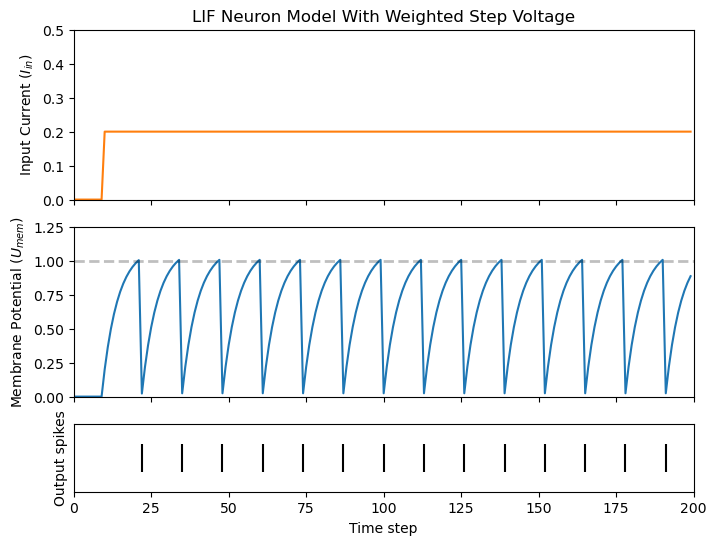

In [8]:
def leaky_integrate_and_fire(mem, x, w, beta, threshold=1):
    """ 
    Leaky integrate-and-fire neuron model.
    Args:
    mem (float): membrane potential
    x (float): input current
    w (float): weight
    beta (float): decay rate
    threshold (float): threshold for spiking
    Returns:
    spk (int): binary spike signal
    mem (float): updated membrane potential
    """
    spk = (mem > threshold)  # if membrane exceeds threshold, spk=1, else, 0
    mem = beta * mem + w*x - spk*threshold
    return spk, mem



# set neuronal parameters

delta_t = torch.tensor(1e-3)

tau = torch.tensor(5e-3)

beta = torch.exp(-delta_t/tau)

print(f"The decay rate is: {beta:.3f}")


num_steps = 200


# initialize inputs/outputs + small step current input

x = torch.cat((torch.zeros(10), torch.ones(190)*0.5), 0)

mem = torch.zeros(1)

spk_out = torch.zeros(1)

mem_rec = []

spk_rec = []


# parameters

w = 0.4

beta = 0.819


# classsnntorch._neurons.leaky.Leaky(beta, threshold=1.0, spike_grad=None, surrogate_disable=False, init_hidden=False, inhibition=False, learn_beta=False, learn_threshold=False, reset_mechanism='subtract', state_quant=False, output=False, graded_spikes_factor=1.0, learn_graded_spikes_factor=False, reset_delay=True)[source]

lif = snn.Leaky(beta, threshold=1.0, reset_mechanism='subtract')

# neuron simulation

for step in range(num_steps):
    spk, mem = leaky_integrate_and_fire(mem, x[step], w=w, beta=beta)

    # spk, mem = lif(x[step], mem) ?????????
    mem_rec.append(mem)
    spk_rec.append(spk)


# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)


plot_cur_mem_spk(x*w, mem_rec, spk_rec, thr_line=1, ylim_max1=0.5,

                 title="LIF Neuron Model With Weighted Step Voltage")

### And now, with randomized spike inputs


The decay rate is: 0.819
input current shape: torch.Size([200]) membrane potential shape: torch.Size([200, 1]) spike shape: torch.Size([200, 1])
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
tensor([[0.0664, 0.0544, 0.0445, 0.0364, 0.0298, 0.0244, 0.4200, 0.3439, 0.2815,
         0.2305]])
tensor([[False, False, False, False, False, False, False, False, False, False]])
tensor([0.])
tensor([False])


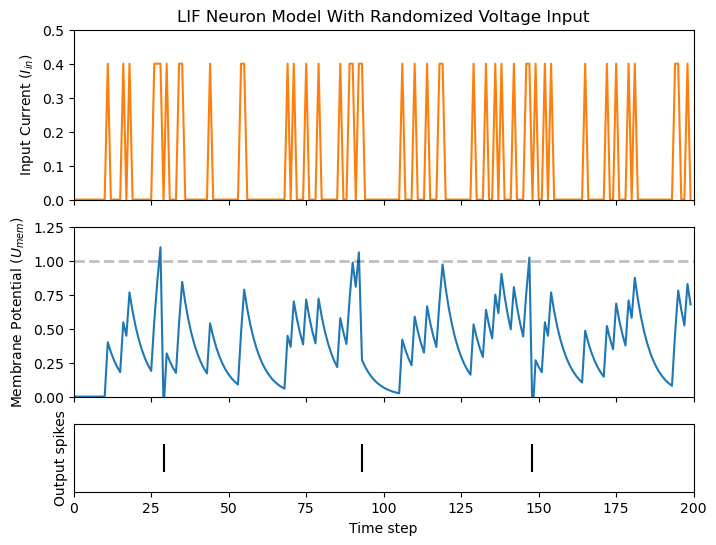

In [9]:
num_steps = 200

# same code but with randomized spike input (majority of input is 0, the rest is 1 at random intervals)
x = torch.cat((torch.zeros(10),
               (torch.randint(0, 100, (190,)) > 80).float()),
              0)
mem_rec = []
spk_rec = []


mem_temp = torch.zeros(1)
spk_out_temp = torch.zeros(1)

# parameters
w = 0.4
delta_t = torch.tensor(1e-3)
tau = torch.tensor(5e-3)
beta = torch.exp(-delta_t/tau)
print(f"The decay rate is: {beta:.3f}")


# neuron simulation
for step in range(num_steps):
    spk_out_temp, mem_temp = leaky_integrate_and_fire(
        mem_temp, x[step], w=w, beta=beta)
    mem_rec.append(mem_temp)
    spk_rec.append(spk_out_temp)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

print("input current shape:", x.shape, "membrane potential shape:",
      mem_rec.shape, "spike shape:", spk_rec.shape)

print(x[100:110])
print(mem_rec[100:110].T)
print(spk_rec[100:110].T)
print(mem_rec[0])
print(spk_rec[0])

plot_cur_mem_spk(x*w, mem_rec, spk_rec, thr_line=1, ylim_max1=0.5,
                 title="LIF Neuron Model With Randomized Voltage Input")


## Defining a small SNN networks working on MNIST

In [10]:
subset = 10
mnist_train = utils.data_subset(mnist_train, subset)
mnist_test = utils.data_subset(mnist_test, subset)  # Reduce the size of mnist_test
print(f"The size of mnist_train is {len(mnist_train)}")
print(f"The size of mnist_test is {len(mnist_test)}")  # Print the size of mnist_test

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

The size of mnist_train is 600
The size of mnist_test is 1000


### FeedForward network

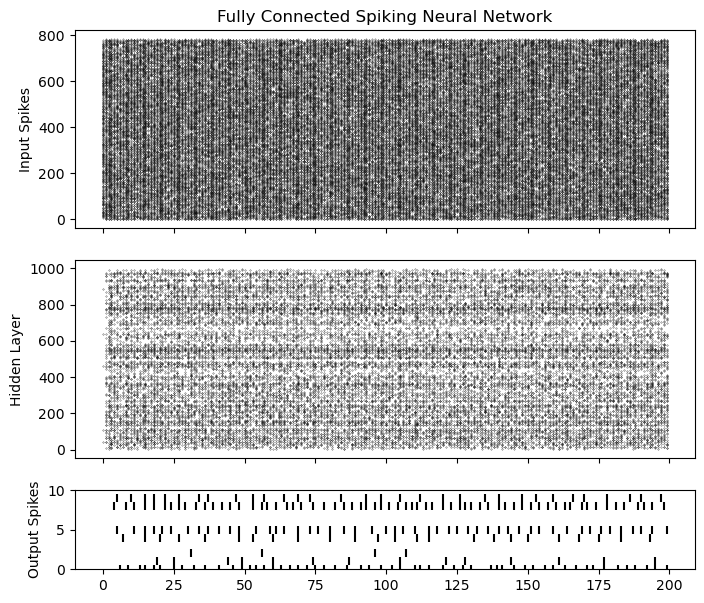

In [11]:
import torch.nn as nn
from snntorch import surrogate


# neuron and simulation parameters
spike_grad = surrogate.fast_sigmoid(slope=25)
beta = 0.5
num_steps = 200

class SpikingNet(nn.Module):
    def __init__(self, num_inputs=784, num_hidden=1000, num_outputs=10, beta=0.99):
        super(SpikingNet, self).__init__()
        # Define the first fully connected layer
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        # Define the first leaky integrate-and-fire neuron
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        # Define the second fully connected layer
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        # Define the second leaky integrate-and-fire neuron
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        # Initialize the membrane potentials for the neurons
        self.mem1 = self.lif1.init_leaky()
        self.mem2 = self.lif2.init_leaky()

    def forward(self, spk_in):
        # Initialize lists to record membrane potentials and spikes
        mem2_rec = []
        spk1_rec = []
        spk2_rec = []
        # Loop over the input spikes
        for step in range(spk_in.size(0)):
            # Compute the post-synaptic current (input I) for the first layer
            cur1 = self.fc1(spk_in[step])
            # Compute the spikes and membrane potentials for the first layer
            spk1, self.mem1 = self.lif1(cur1, self.mem1)
            # Compute the post-synaptic current for the second layer 
            cur2 = self.fc2(spk1)
            # Compute the spikes and membrane potentials for the second layer
            spk2, self.mem2 = self.lif2(cur2, self.mem2)
            # Record the membrane potentials and spikes
            mem2_rec.append(self.mem2)
            spk1_rec.append(spk1)
            spk2_rec.append(spk2)
        # Return the recorded membrane potentials and spikes
        return torch.stack(spk2_rec), torch.stack(mem2_rec), torch.stack(spk1_rec)

# Instantiate the network
net = SpikingNet()

# Generate input spikes
spk_in = spikegen.rate_conv(torch.rand((num_steps, 784))).unsqueeze(1)

# Run the network
spk2_rec, mem2_rec, spk1_rec  = net(spk_in)

# Plot the spikes
plot_snn_spikes(spk_in, spk1_rec, spk2_rec, "Fully Connected Spiking Neural Network")

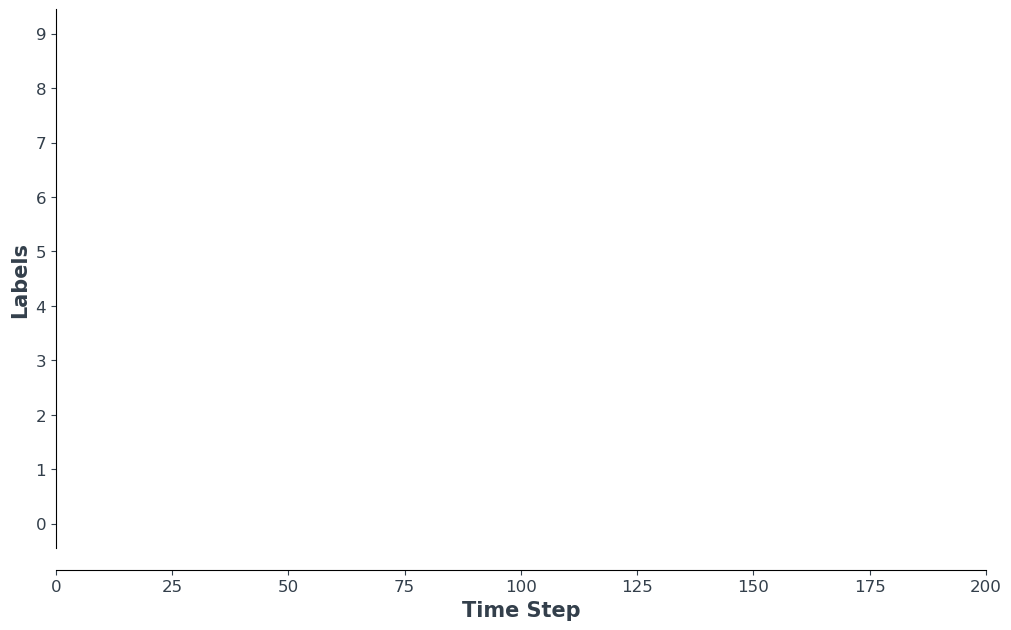

In [12]:
from IPython.display import HTML

fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels=['0', '1', '2', '3', '4', '5', '6', '7', '8','9']
spk2_rec = spk2_rec.squeeze(1).detach().cpu()

# plt.rcParams['animation.ffmpeg_path'] = 'C:\\path\\to\\your\\ffmpeg.exe'

#  Plot spike count histogram
anim = splt.spike_count(spk2_rec, fig, ax, labels=labels, animate=True)
HTML(anim.to_html5_video())
# anim.save("spike_bar.mp4")

In [13]:
import tqdm
from snntorch import functional as SF


def forward_pass(net, num_steps, data):
    mem_rec = []
    spk_rec = []
    utils.reset(net)  # resets hidden states for all LIF neurons in net
    for _ in range(num_steps):
        spk_out, mem_out, _ = net(data)
        spk_rec.append(spk_out)
        mem_rec.append(mem_out)
    return torch.stack(spk_rec).cuda(), torch.stack(mem_rec).cuda()


def batch_accuracy(train_dataloader, net, num_steps):
  with torch.no_grad():
    total = 0
    acc = 0
    net.eval()

    train_dataloader = iter(train_dataloader)
    for data, targets in train_dataloader:
      data = data.cuda()
      data = data.view(data.size(0), -1)
      targets = targets.cuda()
      spk_rec, _ = forward_pass(net, num_steps, data)

      acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
      total += spk_rec.size(1)

  return acc/total


```python 
import torch.optim as optim
# Training the network on MNIST

## MNIST include defined above  

net = SpikingNet().cuda()
criterion = SF.ce_rate_loss()
optimizer = optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

## Training loop
num_epochs = 5
loss_hist = []
test_acc_hist = []
counter = 0

# Outer training loop
for epoch in tqdm.trange(num_epochs):
    # Training loop
    for data, targets in iter(train_loader):
        data = data.cuda()
        data = data.view(data.size(0), -1)  # Flatten the data
        targets =targets.cuda()

        # forward pass
        net.train()
        spk_rec, _ = forward_pass(net, num_steps, data)

        # initialize the loss & sum over time
        loss_val = criterion(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward(retain_graph=True)
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        if counter % 50 == 0:
            with torch.no_grad():
                net.eval()
                test_acc = batch_accuracy(test_loader, net, num_steps)
                print(f"Iteration {counter}, Test Acc: {test_acc * 100:.2f}%\n")
                test_acc_hist.append(test_acc.item())
        counter += 1

```